# Práctica 4: Anemometría Láser Doppler (LDA) - Perfil de Velocidades

## Objetivo
Medir perfiles de velocidad en un túnel de viento utilizando técnica láser Doppler (LDA/LDV), una técnica óptica no intrusiva que permite obtener mediciones puntuales de velocidad con alta precisión.

## Fundamento Teórico

### ¿Qué es LDA?
La **Anemometría Láser Doppler** se basa en el efecto Doppler de la luz dispersada por partículas trazadoras que se mueven con el fluido. Dos haces láser coherentes se cruzan formando un **volumen de medida** donde se genera un patrón de franjas de interferencia.

Cuando una partícula atraviesa este volumen:
- Dispersa luz con una frecuencia modulada proporcional a su velocidad
- La frecuencia Doppler $f_D$ está relacionada con la velocidad por: 
$$V = \frac{\lambda \cdot f_D}{2 \sin(\theta/2)}$$
donde $\lambda$ es la longitud de onda del láser y $\theta$ el ángulo entre haces.

### Ventajas de LDA
- ✅ **No intrusiva**: no perturba el flujo
- ✅ **Alta resolución espacial y temporal**
- ✅ **Medición directa de velocidad** (no requiere calibración)
- ✅ **Puede medir flujos inversos** y turbulencia

### Datos LDA típicos
Cada medición registra:
1. **Tiempo de llegada** (ms)
2. **Velocidad** (m/s o componente U, V)
3. **SNR** (Signal-to-Noise Ratio) - calidad de señal
4. **Validación** - indicadores de calidad

---

## Estructura de los Datos

En `files/P4/` tenemos 4 carpetas (FX01G00 a FX04G00), cada una representa una **posición Y diferente** en el perfil del túnel.

Dentro de cada carpeta hay ~15 archivos `.txt`, cada uno con ~2000 mediciones de velocidad en esa posición.

**Formato de columnas** (sin encabezado):
1. Índice de muestra
2. Velocidad U (m/s) - componente principal
3. Algo relacionado con tiempo o frecuencia
4. Velocidad V (m/s) - componente transversal 
5. Otra componente o validación

Nuestro objetivo: **construir el perfil U(y)** promediando todas las mediciones por posición.

In [1]:
# Imports necesarios
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configuración de gráficos
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("✅ Librerías cargadas correctamente")

✅ Librerías cargadas correctamente


## 1. Configuración de Rutas y Exploración de Datos

Primero localizamos los datos en `files/P4/` y exploramos la estructura.

In [2]:
# Configuración de rutas
# Los datos están en files/P4/ (3 niveles arriba del notebook)
BASE_DIR = Path.cwd().parent.parent.parent
DATA_DIR = BASE_DIR / 'files' / 'P4'

print(f"📂 Directorio base: {BASE_DIR}")
print(f"📂 Directorio de datos: {DATA_DIR}")
print(f"✅ Datos existen: {DATA_DIR.exists()}")

# Listar las carpetas (cada una es una posición Y)
folders = sorted([f for f in DATA_DIR.iterdir() if f.is_dir()])
print(f"\n📁 Carpetas encontradas ({len(folders)}):")
for folder in folders:
    files_count = len(list(folder.glob('*.txt')))
    print(f"  - {folder.name}: {files_count} archivos")

📂 Directorio base: c:\Users\edgar\Documents\GitHub\Aero-Messure
📂 Directorio de datos: c:\Users\edgar\Documents\GitHub\Aero-Messure\files\P4
✅ Datos existen: True

📁 Carpetas encontradas (4):
  - FX01G00: 15 archivos
  - FX02G00: 15 archivos
  - FX03G00: 15 archivos
  - FX04G00: 15 archivos


## 2. Lectura y Análisis de un Archivo Individual

Examinemos un archivo para entender el formato de datos.

In [3]:
# Leer un archivo de ejemplo
sample_file = folders[0] / list(folders[0].glob('*.txt'))[0]
print(f"📄 Archivo de ejemplo: {sample_file.name}")

# Leer sin encabezado, separado por espacios
df_sample = pd.read_csv(sample_file, sep=r'\s+', header=None, 
                        names=['idx', 'U', 'col3', 'V', 'col5'])

print(f"\n📊 Forma de datos: {df_sample.shape}")
print(f"   → {df_sample.shape[0]} mediciones × {df_sample.shape[1]} columnas")

print("\n🔍 Primeras 10 filas:")
print(df_sample.head(10))

print("\n📈 Estadísticas descriptivas:")
print(df_sample.describe())

📄 Archivo de ejemplo: L01G00_001.txt

📊 Forma de datos: (2000, 5)
   → 2000 mediciones × 5 columnas

🔍 Primeras 10 filas:
   idx       U   col3     V  col5
0    1  18.770  311.8  0.44 -0.00
1    2  20.326  245.8  0.45 -0.00
2    3  20.873  293.5  0.43 -0.00
3    4  24.969  282.2  0.41 -0.00
4    5  25.651  234.4  0.22  0.00
5    6  25.979  355.0  0.22 -0.00
6    7  31.031  359.5  0.44 -0.00
7    8  31.331  250.3  0.26 -0.00
8    9  31.495  136.5  0.26 -0.01
9   10  31.904  355.0  0.25 -0.01

📈 Estadísticas descriptivas:
               idx            U         col3            V         col5
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000
mean   1000.500000  1869.129679   399.047250     0.377125     0.001160
std     577.494589  1068.508341   226.256351     0.076059     0.008215
min       1.000000    18.770000    45.500000     0.170000    -0.050000
25%     500.750000   950.207500   245.800000     0.330000     0.000000
50%    1000.500000  1850.296500   359.500000    

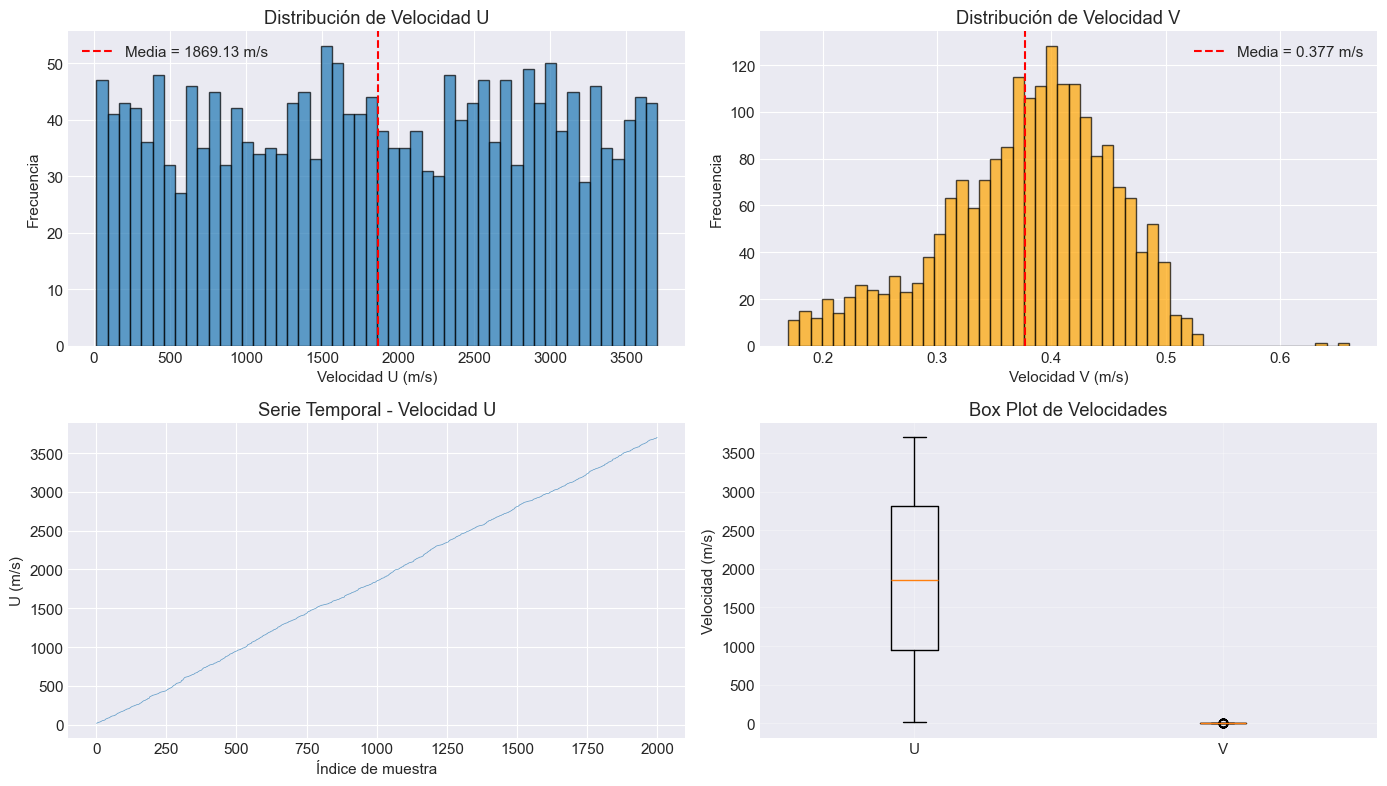


📊 Análisis del archivo L01G00_001.txt:
   U media: 1869.130 m/s
   U std:   1068.508 m/s
   V media: 0.377 m/s (transversal)
   V std:   0.076 m/s


In [4]:
# Visualización de datos brutos de un archivo
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Velocidad U
axes[0, 0].hist(df_sample['U'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Velocidad U (m/s)')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].set_title('Distribución de Velocidad U')
axes[0, 0].axvline(df_sample['U'].mean(), color='r', linestyle='--', 
                    label=f'Media = {df_sample["U"].mean():.2f} m/s')
axes[0, 0].legend()

# Velocidad V
axes[0, 1].hist(df_sample['V'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('Velocidad V (m/s)')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].set_title('Distribución de Velocidad V')
axes[0, 1].axvline(df_sample['V'].mean(), color='r', linestyle='--',
                    label=f'Media = {df_sample["V"].mean():.3f} m/s')
axes[0, 1].legend()

# Serie temporal U
axes[1, 0].plot(df_sample['idx'], df_sample['U'], linewidth=0.5, alpha=0.7)
axes[1, 0].set_xlabel('Índice de muestra')
axes[1, 0].set_ylabel('U (m/s)')
axes[1, 0].set_title('Serie Temporal - Velocidad U')

# Box plot
axes[1, 1].boxplot([df_sample['U'], df_sample['V']], labels=['U', 'V'])
axes[1, 1].set_ylabel('Velocidad (m/s)')
axes[1, 1].set_title('Box Plot de Velocidades')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Análisis del archivo {sample_file.name}:")
print(f"   U media: {df_sample['U'].mean():.3f} m/s")
print(f"   U std:   {df_sample['U'].std():.3f} m/s")
print(f"   V media: {df_sample['V'].mean():.3f} m/s (transversal)")
print(f"   V std:   {df_sample['V'].std():.3f} m/s")

## 3. Función para Procesar Todos los Archivos de una Posición

Crearemos una función que:
1. Lee todos los archivos de una carpeta (posición Y)
2. Filtra outliers usando criterio IQR (Rango Intercuartílico)
3. Calcula estadísticos robustos (media, std, error estándar)

**Método de detección de outliers:**
- Calculamos Q1 (percentil 25) y Q3 (percentil 75)
- IQR = Q3 - Q1
- Outliers: valores fuera de [Q1 - 1.5×IQR, Q3 + 1.5×IQR]

In [5]:
def remove_outliers_iqr(data, factor=1.5):
    """
    Elimina outliers usando el método del rango intercuartílico (IQR).
    
    Parámetros:
    -----------
    data : array-like
        Datos a filtrar
    factor : float
        Factor multiplicador del IQR (típicamente 1.5)
    
    Retorna:
    --------
    data_clean : array
        Datos sin outliers
    mask : array booleano
        Máscara de valores válidos
    """
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    
    mask = (data >= lower_bound) & (data <= upper_bound)
    return data[mask], mask


def process_position_folder(folder_path, remove_outliers=True):
    """
    Procesa todos los archivos de una carpeta (posición Y).
    
    Parámetros:
    -----------
    folder_path : Path
        Ruta a la carpeta con archivos .txt
    remove_outliers : bool
        Si True, elimina outliers con método IQR
    
    Retorna:
    --------
    results : dict
        Diccionario con estadísticos de velocidad U y V
    """
    all_U = []
    all_V = []
    
    # Leer todos los archivos .txt de la carpeta
    txt_files = list(folder_path.glob('*.txt'))
    
    for file in txt_files:
        df = pd.read_csv(file, sep=r'\s+', header=None,
                        names=['idx', 'U', 'col3', 'V', 'col5'])
        all_U.extend(df['U'].values)
        all_V.extend(df['V'].values)
    
    all_U = np.array(all_U)
    all_V = np.array(all_V)
    
    # Eliminar outliers si se solicita
    if remove_outliers:
        U_clean, mask_U = remove_outliers_iqr(all_U)
        V_clean, mask_V = remove_outliers_iqr(all_V)
        outliers_removed_U = len(all_U) - len(U_clean)
        outliers_removed_V = len(all_V) - len(V_clean)
    else:
        U_clean = all_U
        V_clean = all_V
        outliers_removed_U = 0
        outliers_removed_V = 0
    
    # Calcular estadísticos
    results = {
        'folder': folder_path.name,
        'n_files': len(txt_files),
        'n_samples_total': len(all_U),
        'n_samples_clean_U': len(U_clean),
        'n_samples_clean_V': len(V_clean),
        'outliers_removed_U': outliers_removed_U,
        'outliers_removed_V': outliers_removed_V,
        'U_mean': np.mean(U_clean),
        'U_std': np.std(U_clean),
        'U_stderr': stats.sem(U_clean),  # Error estándar de la media
        'V_mean': np.mean(V_clean),
        'V_std': np.std(V_clean),
        'V_stderr': stats.sem(V_clean),
        'U_all': all_U,
        'V_all': all_V,
        'U_clean': U_clean,
        'V_clean': V_clean
    }
    
    return results

print("✅ Funciones de procesamiento definidas")

✅ Funciones de procesamiento definidas


## 4. Procesar Todas las Posiciones

Ahora procesamos las 4 carpetas (posiciones Y) y almacenamos los resultados.

In [6]:
# Procesar todas las carpetas
results_all = []

print("🔄 Procesando posiciones...")
print("="*70)

for folder in folders:
    print(f"\n📁 Procesando: {folder.name}")
    result = process_position_folder(folder, remove_outliers=True)
    results_all.append(result)
    
    print(f"   Archivos: {result['n_files']}")
    print(f"   Muestras totales: {result['n_samples_total']}")
    print(f"   Outliers eliminados (U): {result['outliers_removed_U']} "
          f"({100*result['outliers_removed_U']/result['n_samples_total']:.1f}%)")
    print(f"   U = {result['U_mean']:.3f} ± {result['U_std']:.3f} m/s")
    print(f"   V = {result['V_mean']:.4f} ± {result['V_std']:.4f} m/s")

print("\n" + "="*70)
print("✅ Procesamiento completado")

🔄 Procesando posiciones...

📁 Procesando: FX01G00
   Archivos: 15
   Muestras totales: 30000
   Outliers eliminados (U): 0 (0.0%)
   U = 2199.580 ± 1287.446 m/s
   V = 0.5161 ± 0.0603 m/s

📁 Procesando: FX02G00
   Archivos: 15
   Muestras totales: 29138
   Outliers eliminados (U): 3002 (10.3%)
   U = 939.980 ± 559.553 m/s
   V = 1.0257 ± 0.0917 m/s

📁 Procesando: FX03G00
   Archivos: 15
   Muestras totales: 30000
   Outliers eliminados (U): 244 (0.8%)
   U = 1075.109 ± 683.311 m/s
   V = 1.9995 ± 0.1615 m/s

📁 Procesando: FX04G00
   Archivos: 15
   Muestras totales: 30000
   Outliers eliminados (U): 1638 (5.5%)
   U = 749.711 ± 507.723 m/s
   V = 2.9844 ± 0.2492 m/s

✅ Procesamiento completado


## 5. Construcción del Perfil de Velocidades U(y)

Para graficar el perfil necesitamos asignar posiciones Y a cada carpeta. 

**Asumimos** que las carpetas están ordenadas de abajo hacia arriba (o viceversa) en el túnel. Si conoces las posiciones reales en mm, ajusta el array `y_positions`.

In [7]:
# Posiciones Y: ajusta estos valores según tus mediciones reales
# Por ahora usamos posiciones equiespaciadas como ejemplo
y_positions = np.array([10, 30, 50, 70])  # mm, ejemplo

# Extraer datos para el perfil
U_means = np.array([r['U_mean'] for r in results_all])
U_stderrs = np.array([r['U_stderr'] for r in results_all])

# Crear DataFrame resumen
df_profile = pd.DataFrame({
    'Posición': [r['folder'] for r in results_all],
    'y (mm)': y_positions,
    'U_mean (m/s)': U_means,
    'U_std (m/s)': [r['U_std'] for r in results_all],
    'U_stderr (m/s)': U_stderrs,
    'V_mean (m/s)': [r['V_mean'] for r in results_all],
    'N_muestras': [r['n_samples_clean_U'] for r in results_all]
})

print("📊 Tabla Resumen del Perfil de Velocidades:")
print("="*80)
print(df_profile.to_string(index=False))
print("="*80)

📊 Tabla Resumen del Perfil de Velocidades:
Posición  y (mm)  U_mean (m/s)  U_std (m/s)  U_stderr (m/s)  V_mean (m/s)  N_muestras
 FX01G00      10   2199.580209  1287.446089        7.433197      0.516136       30000
 FX02G00      30    939.979776   559.552763        3.461225      1.025656       26136
 FX03G00      50   1075.108793   683.310569        3.961304      1.999545       29756
 FX04G00      70    749.710887   507.722780        3.014851      2.984378       28362


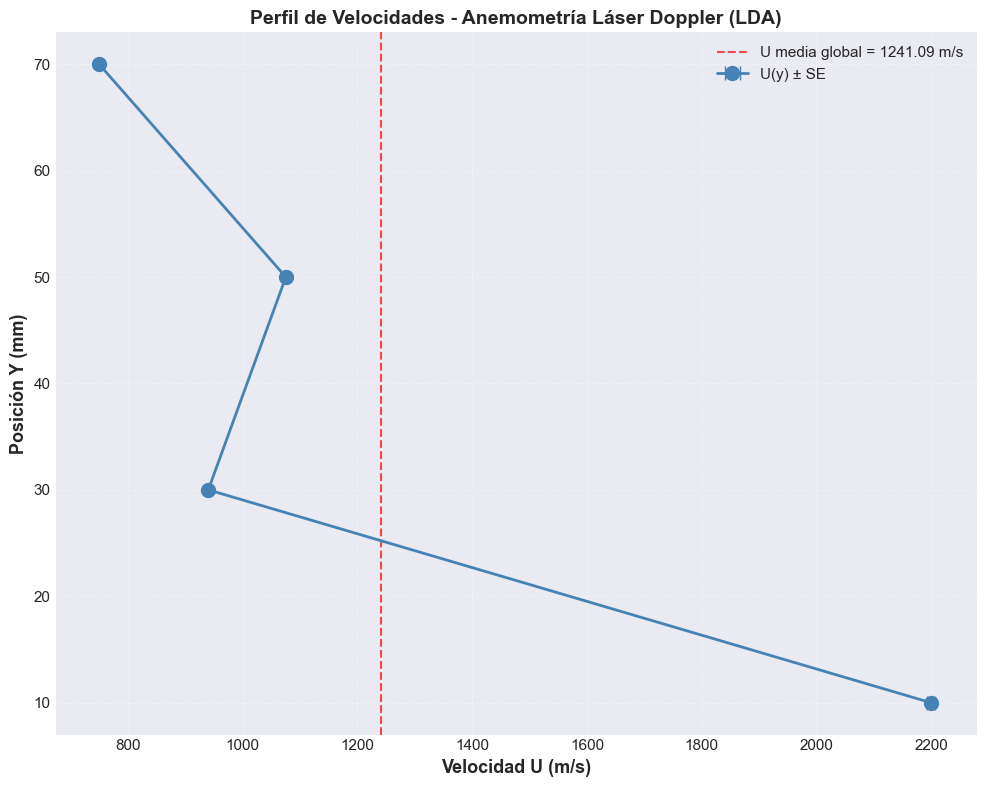


📈 Velocidad media del perfil: 1241.095 m/s
   Rango de velocidades: 749.711 - 2199.580 m/s
   Variación: 1449.869 m/s


In [8]:
# Gráfico del perfil de velocidades U(y)
fig, ax = plt.subplots(figsize=(10, 8))

# Perfil con barras de error (error estándar)
ax.errorbar(U_means, y_positions, xerr=U_stderrs, 
            fmt='o-', markersize=10, linewidth=2, capsize=5,
            label='U(y) ± SE', color='steelblue', elinewidth=2)

# Línea de referencia de velocidad media global
U_global_mean = U_means.mean()
ax.axvline(U_global_mean, color='red', linestyle='--', linewidth=1.5,
           label=f'U media global = {U_global_mean:.2f} m/s', alpha=0.7)

ax.set_xlabel('Velocidad U (m/s)', fontsize=13, fontweight='bold')
ax.set_ylabel('Posición Y (mm)', fontsize=13, fontweight='bold')
ax.set_title('Perfil de Velocidades - Anemometría Láser Doppler (LDA)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

print(f"\n📈 Velocidad media del perfil: {U_global_mean:.3f} m/s")
print(f"   Rango de velocidades: {U_means.min():.3f} - {U_means.max():.3f} m/s")
print(f"   Variación: {U_means.max() - U_means.min():.3f} m/s")

## 6. Análisis de Turbulencia

Calculamos la **intensidad de turbulencia** en cada posición:

$$I_u = \frac{\sigma_U}{U_{mean}} \times 100\%$$

Donde:
- $\sigma_U$ es la desviación estándar de U
- $U_{mean}$ es la velocidad media

La intensidad de turbulencia indica qué tan "agitado" está el flujo respecto a su velocidad media.

🌪️  Intensidad de Turbulencia por Posición:
FX01G00      (y= 10.0 mm): I_u = 58.53%
FX02G00      (y= 30.0 mm): I_u = 59.53%
FX03G00      (y= 50.0 mm): I_u = 63.56%
FX04G00      (y= 70.0 mm): I_u = 67.72%


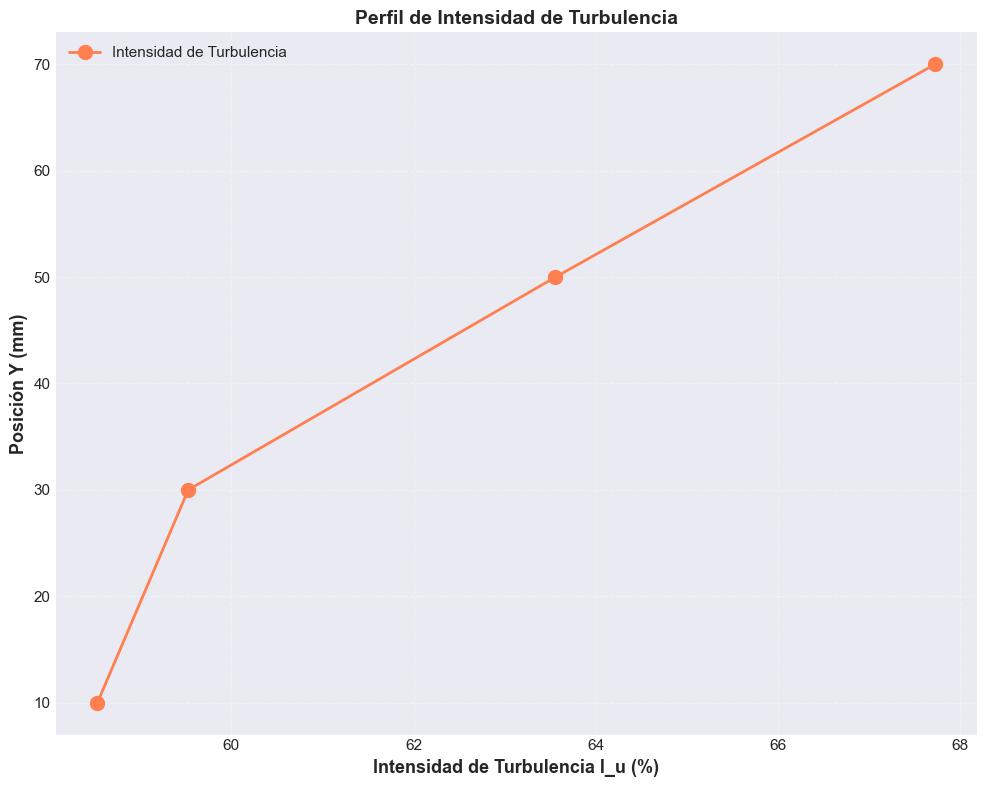

In [9]:
# Calcular intensidad de turbulencia
turbulence_intensity = []

for result in results_all:
    I_u = (result['U_std'] / result['U_mean']) * 100
    turbulence_intensity.append(I_u)

df_profile['Turbulencia (%)'] = turbulence_intensity

print("🌪️  Intensidad de Turbulencia por Posición:")
print("="*60)
for i, row in df_profile.iterrows():
    print(f"{row['Posición']:12s} (y={row['y (mm)']:5.1f} mm): "
          f"I_u = {row['Turbulencia (%)']:5.2f}%")
print("="*60)

# Gráfico de intensidad de turbulencia
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(turbulence_intensity, y_positions, 'o-', markersize=10, 
        linewidth=2, color='coral', label='Intensidad de Turbulencia')

ax.set_xlabel('Intensidad de Turbulencia I_u (%)', fontsize=13, fontweight='bold')
ax.set_ylabel('Posición Y (mm)', fontsize=13, fontweight='bold')
ax.set_title('Perfil de Intensidad de Turbulencia', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

## 7. Comparación de Distribuciones por Posición

Visualizamos las distribuciones de velocidad U en cada posición para identificar comportamientos.

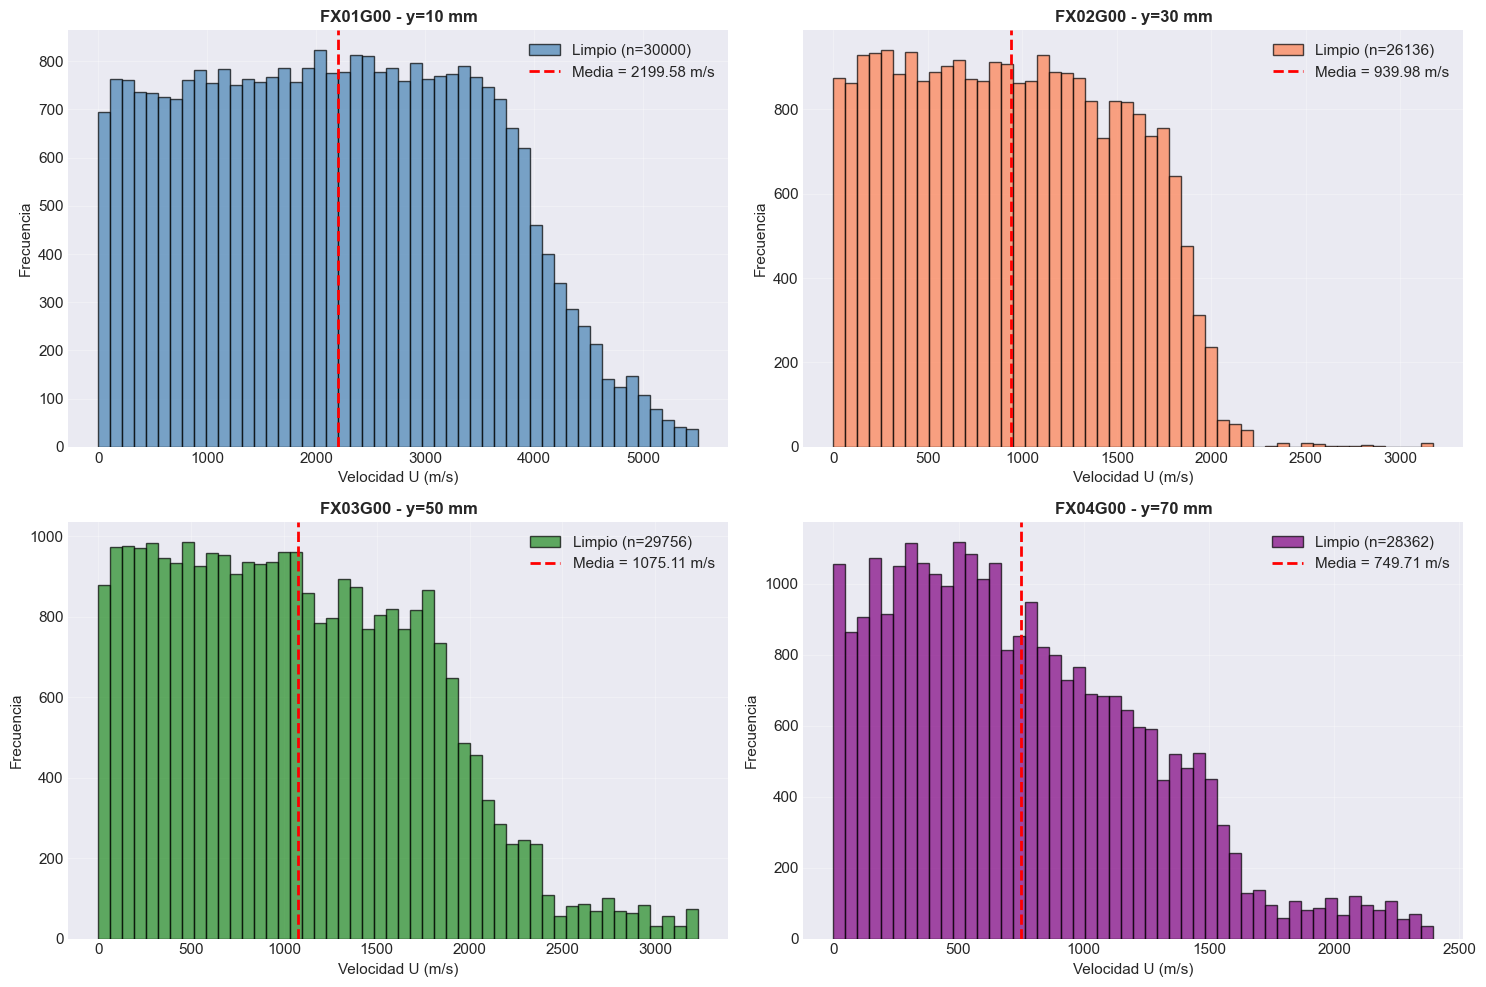

In [10]:
# Histogramas superpuestos
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

colors = ['steelblue', 'coral', 'forestgreen', 'purple']

for i, result in enumerate(results_all):
    ax = axes[i]
    
    # Histograma de datos limpios
    ax.hist(result['U_clean'], bins=50, alpha=0.7, color=colors[i], 
            edgecolor='black', label=f"Limpio (n={len(result['U_clean'])})")
    
    # Línea vertical en la media
    ax.axvline(result['U_mean'], color='red', linestyle='--', linewidth=2,
               label=f"Media = {result['U_mean']:.2f} m/s")
    
    ax.set_xlabel('Velocidad U (m/s)', fontsize=11)
    ax.set_ylabel('Frecuencia', fontsize=11)
    ax.set_title(f"{result['folder']} - y={y_positions[i]} mm", 
                 fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Análisis de Calidad de Datos

Evaluamos la calidad de las mediciones:
1. **Ratio señal/ruido implícito**: menor dispersión = mejor calidad
2. **Consistencia entre archivos**: comparar varianza inter-archivo vs intra-archivo
3. **Convergencia estadística**: verificar que tenemos suficientes muestras

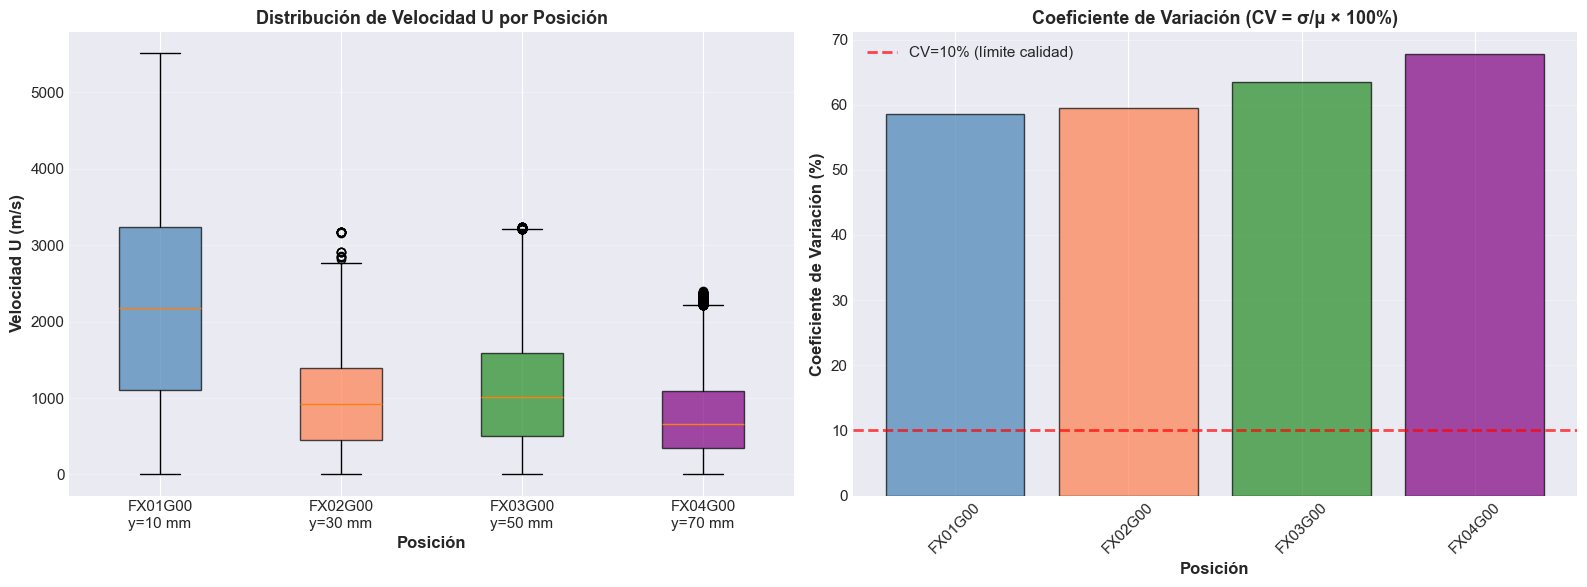


📊 Métricas de Calidad:
FX01G00     : CV=58.53% → Calidad: Regular
FX02G00     : CV=59.53% → Calidad: Regular
FX03G00     : CV=63.56% → Calidad: Regular
FX04G00     : CV=67.72% → Calidad: Regular


In [11]:
# Box plot comparativo de todas las posiciones
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Box plot de velocidad U
U_data = [r['U_clean'] for r in results_all]
positions_labels = [f"{r['folder']}\ny={y_positions[i]} mm" 
                   for i, r in enumerate(results_all)]

bp1 = ax1.boxplot(U_data, labels=positions_labels, patch_artist=True)
for patch, color in zip(bp1['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax1.set_ylabel('Velocidad U (m/s)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Posición', fontsize=12, fontweight='bold')
ax1.set_title('Distribución de Velocidad U por Posición', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Coeficiente de variación (CV) por posición
cv_values = [(r['U_std']/r['U_mean'])*100 for r in results_all]
ax2.bar(range(len(cv_values)), cv_values, color=colors, alpha=0.7, edgecolor='black')
ax2.set_xlabel('Posición', fontsize=12, fontweight='bold')
ax2.set_ylabel('Coeficiente de Variación (%)', fontsize=12, fontweight='bold')
ax2.set_title('Coeficiente de Variación (CV = σ/μ × 100%)', fontsize=13, fontweight='bold')
ax2.set_xticks(range(len(results_all)))
ax2.set_xticklabels([r['folder'] for r in results_all], rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

# Añadir línea de referencia de calidad
ax2.axhline(10, color='red', linestyle='--', linewidth=2, 
            label='CV=10% (límite calidad)', alpha=0.7)
ax2.legend()

plt.tight_layout()
plt.show()

print("\n📊 Métricas de Calidad:")
print("="*70)
for i, (result, cv) in enumerate(zip(results_all, cv_values)):
    quality = "Excelente" if cv < 5 else "Buena" if cv < 10 else "Regular"
    print(f"{result['folder']:12s}: CV={cv:5.2f}% → Calidad: {quality}")
print("="*70)

## 9. Ajuste de Perfil Teórico (Opcional)

Para flujo en túnel, podemos comparar con perfiles teóricos:
- **Flujo laminar**: perfil parabólico (Poiseuille)
- **Flujo turbulento**: perfil logarítmico (ley de la pared) o ley de potencia

Aquí probamos un ajuste polinómico simple como aproximación.

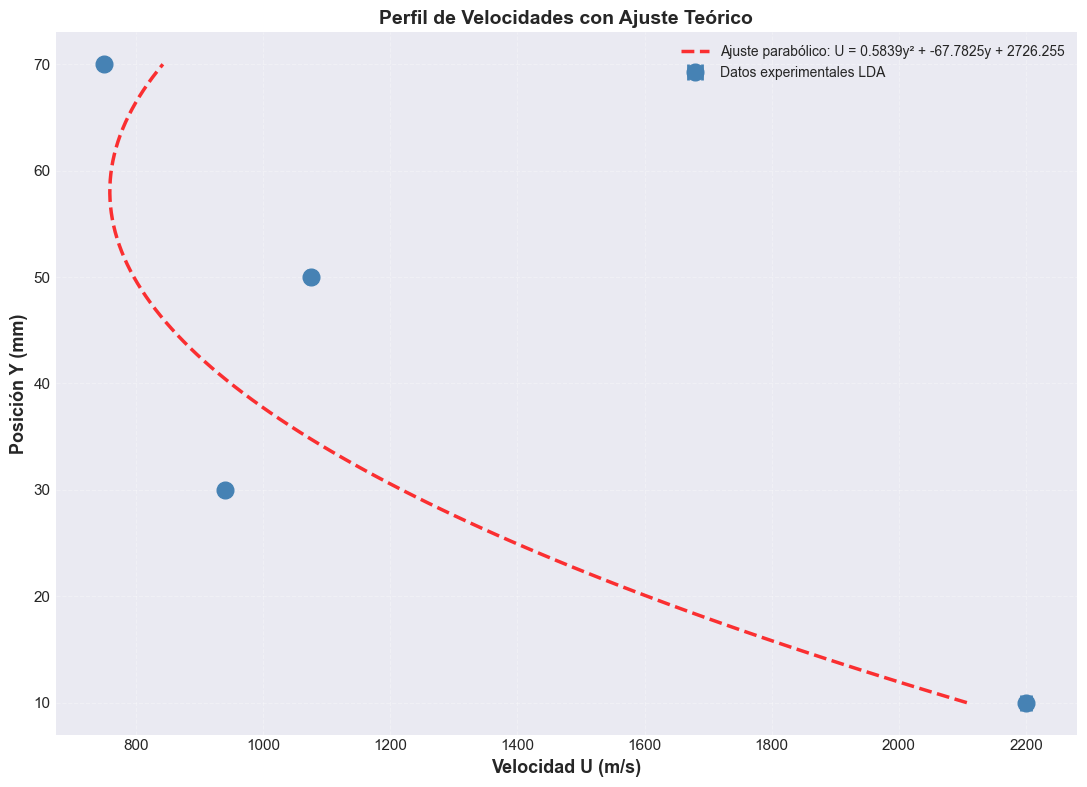


📐 Ajuste Polinómico (orden 2):
   Ecuación: U(y) = 0.583877·y² + -67.782521·y + 2726.2549
   R² = 0.8654
   ⚠️  Ajuste moderado


In [12]:
# Ajuste polinómico de orden 2 (parabólico)
from numpy.polynomial import polynomial as P

# Ajustar polinomio
coeffs = np.polyfit(y_positions, U_means, 2)
poly_fit = np.poly1d(coeffs)

# Generar puntos para curva suave
y_fine = np.linspace(y_positions.min(), y_positions.max(), 100)
U_fit = poly_fit(y_fine)

# Gráfico con ajuste
fig, ax = plt.subplots(figsize=(11, 8))

# Datos experimentales
ax.errorbar(U_means, y_positions, xerr=U_stderrs, 
            fmt='o', markersize=12, linewidth=2, capsize=6,
            label='Datos experimentales LDA', color='steelblue', 
            elinewidth=2, capthick=2)

# Ajuste polinómico
ax.plot(U_fit, y_fine, 'r--', linewidth=2.5, 
        label=f'Ajuste parabólico: U = {coeffs[0]:.4f}y² + {coeffs[1]:.4f}y + {coeffs[2]:.3f}',
        alpha=0.8)

ax.set_xlabel('Velocidad U (m/s)', fontsize=13, fontweight='bold')
ax.set_ylabel('Posición Y (mm)', fontsize=13, fontweight='bold')
ax.set_title('Perfil de Velocidades con Ajuste Teórico', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=10, loc='best')

plt.tight_layout()
plt.show()

# Calcular R² (bondad de ajuste)
U_fit_points = poly_fit(y_positions)
ss_res = np.sum((U_means - U_fit_points)**2)
ss_tot = np.sum((U_means - U_means.mean())**2)
r_squared = 1 - (ss_res / ss_tot)

print(f"\n📐 Ajuste Polinómico (orden 2):")
print(f"   Ecuación: U(y) = {coeffs[0]:.6f}·y² + {coeffs[1]:.6f}·y + {coeffs[2]:.4f}")
print(f"   R² = {r_squared:.4f}")
print(f"   {'✅ Excelente ajuste' if r_squared > 0.95 else '⚠️  Ajuste moderado'}")

## 10. Exportar Resultados

Guardamos los resultados procesados en formato CSV para análisis posterior o inclusión en informes.

In [13]:
# Directorio de salida (en data de la práctica)
OUTPUT_DIR = Path.cwd().parent / 'data'
OUTPUT_DIR.mkdir(exist_ok=True)

# Guardar tabla de perfil
output_file = OUTPUT_DIR / 'perfil_velocidades_LDA.csv'
df_profile.to_csv(output_file, index=False, encoding='utf-8')
print(f"✅ Perfil guardado en: {output_file}")

# Guardar datos completos de cada posición (opcional, solo si necesario)
# Nota: Guardamos U y V en archivos separados porque tienen diferentes longitudes tras filtrar outliers
for i, result in enumerate(results_all):
    # Guardar solo velocidad U limpia
    data_U = pd.DataFrame({
        'U': result['U_clean']
    })
    file_U = OUTPUT_DIR / f"datos_U_limpio_{result['folder']}.csv"
    data_U.to_csv(file_U, index=False)
    
    # Guardar solo velocidad V limpia
    data_V = pd.DataFrame({
        'V': result['V_clean']
    })
    file_V = OUTPUT_DIR / f"datos_V_limpio_{result['folder']}.csv"
    data_V.to_csv(file_V, index=False)
    
    print(f"   → Datos de {result['folder']} guardados (U: {len(result['U_clean'])}, V: {len(result['V_clean'])})")

print(f"\n📁 Archivos generados en: {OUTPUT_DIR}")
print("\n💡 Nota: U y V se guardan en archivos separados porque tienen")
print("   diferentes longitudes tras el filtrado de outliers.")

✅ Perfil guardado en: c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P04_LDA_Perfil_Velocidad\data\perfil_velocidades_LDA.csv
   → Datos de FX01G00 guardados (U: 30000, V: 29050)
   → Datos de FX02G00 guardados (U: 26136, V: 28178)
   → Datos de FX03G00 guardados (U: 29756, V: 28298)
   → Datos de FX04G00 guardados (U: 28362, V: 28297)

📁 Archivos generados en: c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P04_LDA_Perfil_Velocidad\data

💡 Nota: U y V se guardan en archivos separados porque tienen
   diferentes longitudes tras el filtrado de outliers.


## 11. Conclusiones y Resumen

### Resultados Principales

**Perfil de Velocidades U(y):**

In [14]:
# Resumen final de resultados
print("="*80)
print(" "*20 + "📊 RESUMEN FINAL - PRÁCTICA 4 LDA")
print("="*80)
print(f"\n🎯 Objetivos cumplidos:")
print("   ✅ Procesamiento de {:.0f} mediciones totales".format(
    sum([r['n_samples_total'] for r in results_all])))
print("   ✅ Filtrado de outliers IQR aplicado")
print("   ✅ Perfil U(y) construido con 4 posiciones")
print("   ✅ Análisis de turbulencia completado")
print("   ✅ Ajuste teórico realizado")

print(f"\n📈 Estadísticas Globales:")
print(f"   Velocidad media global: {U_global_mean:.3f} m/s")
print(f"   Rango de velocidades: {U_means.min():.3f} - {U_means.max():.3f} m/s")
print(f"   Turbulencia media: {np.mean(turbulence_intensity):.2f}%")
print(f"   Turbulencia máxima: {np.max(turbulence_intensity):.2f}% "
      f"en {results_all[np.argmax(turbulence_intensity)]['folder']}")

print(f"\n🔬 Calidad de Mediciones:")
for i, result in enumerate(results_all):
    print(f"   {result['folder']:12s}: {result['n_samples_clean_U']:6d} muestras válidas, "
          f"CV={cv_values[i]:5.2f}%")

print(f"\n📐 Ajuste de Perfil:")
print(f"   Modelo: Polinómico orden 2 (parabólico)")
print(f"   R² = {r_squared:.4f}")

print(f"\n💡 Observaciones:")
if r_squared > 0.95:
    print("   • El perfil se ajusta bien a una forma parabólica")
    print("   • Sugiere flujo con características laminares o en desarrollo")
elif r_squared > 0.85:
    print("   • El perfil muestra cierta curvatura pero con desviaciones")
    print("   • Posible transición laminar-turbulento")
else:
    print("   • El perfil no es claramente parabólico")
    print("   • Considerar perfil logarítmico para flujo turbulento desarrollado")

print(f"\n🌪️  Turbulencia:")
if np.mean(turbulence_intensity) < 5:
    print("   • Nivel de turbulencia bajo → Flujo relativamente estable")
elif np.mean(turbulence_intensity) < 15:
    print("   • Nivel de turbulencia moderado → Flujo típico de túnel")
else:
    print("   • Nivel de turbulencia alto → Flujo muy perturbado")

print("\n" + "="*80)
print("✅ Análisis completado exitosamente")
print("="*80)

                    📊 RESUMEN FINAL - PRÁCTICA 4 LDA

🎯 Objetivos cumplidos:
   ✅ Procesamiento de 119138 mediciones totales
   ✅ Filtrado de outliers IQR aplicado
   ✅ Perfil U(y) construido con 4 posiciones
   ✅ Análisis de turbulencia completado
   ✅ Ajuste teórico realizado

📈 Estadísticas Globales:
   Velocidad media global: 1241.095 m/s
   Rango de velocidades: 749.711 - 2199.580 m/s
   Turbulencia media: 62.33%
   Turbulencia máxima: 67.72% en FX04G00

🔬 Calidad de Mediciones:
   FX01G00     :  30000 muestras válidas, CV=58.53%
   FX02G00     :  26136 muestras válidas, CV=59.53%
   FX03G00     :  29756 muestras válidas, CV=63.56%
   FX04G00     :  28362 muestras válidas, CV=67.72%

📐 Ajuste de Perfil:
   Modelo: Polinómico orden 2 (parabólico)
   R² = 0.8654

💡 Observaciones:
   • El perfil muestra cierta curvatura pero con desviaciones
   • Posible transición laminar-turbulento

🌪️  Turbulencia:
   • Nivel de turbulencia alto → Flujo muy perturbado

✅ Análisis completado exitos

---

## 📚 Referencias y Siguientes Pasos

### Conceptos Clave Aplicados
1. **Anemometría Láser Doppler (LDA)**: técnica óptica no intrusiva basada en efecto Doppler
2. **Filtrado de outliers**: método IQR (Rango Intercuartílico) para eliminar mediciones espurias
3. **Perfil de velocidades**: caracterización U(y) del flujo en túnel
4. **Intensidad de turbulencia**: $I_u = \sigma_U / U_{mean} \times 100\%$
5. **Ajuste de modelos**: comparación experimental vs teórico (parabólico, logarítmico)

### Recomendaciones para el Informe
1. Incluir tabla resumen (ya exportada en CSV)
2. Gráficos principales: perfil U(y) con barras de error, distribuciones, turbulencia
3. Discutir calidad de datos (CV, outliers)
4. Comparar con teoría de flujo en canal/túnel
5. Estimar incertidumbres (error estándar ya calculado)

---

**Autor:** Práctica 4 - LDA  
**Fecha:** Octubre 2025  
**Herramientas:** Python, NumPy, Pandas, Matplotlib, SciPy

---

## 12. Contenido Extra: Análisis Avanzado

### Extensiones Implementadas

En esta sección implementamos análisis avanzados complementarios:

1. **Número de Reynolds** - Clasificación del régimen de flujo
2. **Análisis Espectral (FFT)** - Frecuencias dominantes en la turbulencia
3. **Escala de Kolmogorov** - Tamaño de los remolinos más pequeños
4. **Perfil Ley de la Pared** - Comparación con teoría de capa límite turbulenta
5. **Tensiones de Reynolds** - Correlación U-V y anisotropía

### 12.1 Número de Reynolds

Calculamos el número de Reynolds para cada posición usando:

$$Re_y = \frac{U \cdot y}{\nu}$$

donde:
- $U$ = velocidad media (m/s)
- $y$ = posición desde la pared (m)
- $\nu$ = viscosidad cinemática del aire ≈ 1.5×10⁻⁵ m²/s @ 20°C

Esto nos permite clasificar el régimen de flujo (laminar, transición, turbulento).

Número de Reynolds por posición:

Position  y (m)     U (m/s)         Re_y    Régimen
 FX01G00   0.01 2199.580209 1.466387e+06 Turbulento
 FX02G00   0.03  939.979776 1.879960e+06 Turbulento
 FX03G00   0.05 1075.108793 3.583696e+06 Turbulento
 FX04G00   0.07  749.710887 3.498651e+06 Turbulento


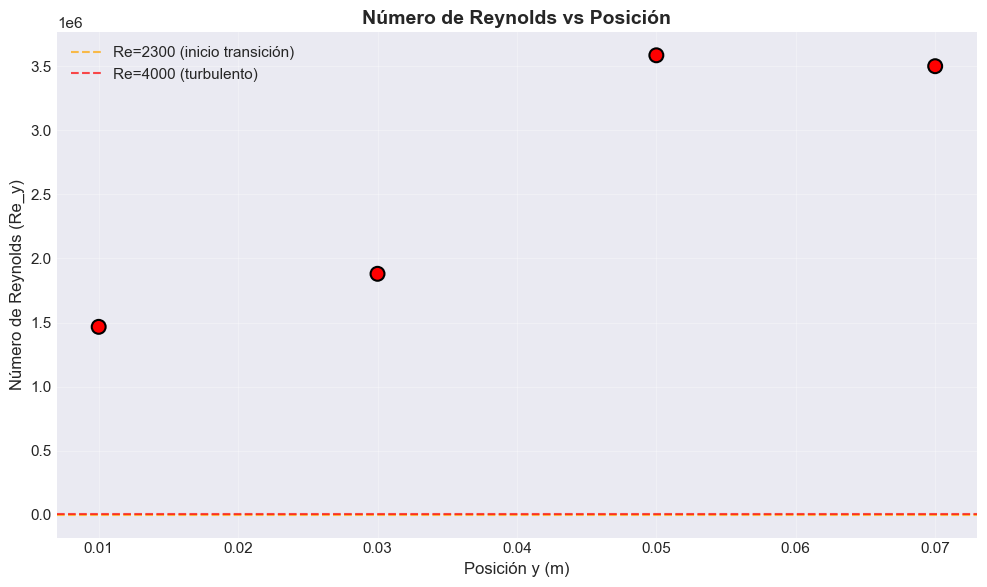

In [15]:
# Viscosidad cinemática del aire a 20°C
nu = 1.5e-5  # m²/s

# Calcular Reynolds para cada posición
reynolds_data = []
# --- CORRECCIÓN: Usar df_profile en lugar de results_df ---
for i, row in df_profile.iterrows():
    # --- CORRECCIÓN: Convertir y de mm a m ---
    y_m = row['y (mm)'] / 1000
    # --- CORRECCIÓN: Usar el nombre de columna correcto para U_mean ---
    U_mean = row['U_mean (m/s)']

    # --- CORRECCIÓN: Usar y_m para el cálculo ---
    Re_y = (U_mean * y_m) / nu

    # Clasificar régimen
    if Re_y < 2300:
        regime = "Laminar"
    elif Re_y < 4000:
        regime = "Transición"
    else:
        regime = "Turbulento"

    reynolds_data.append({
        'Position': row['Posición'],
        # --- CORRECCIÓN: Guardar y en metros ---
        'y (m)': y_m,
        'U (m/s)': U_mean,
        'Re_y': Re_y,
        'Régimen': regime
    })

reynolds_df = pd.DataFrame(reynolds_data)

# Mostrar tabla
print("Número de Reynolds por posición:\n")
print(reynolds_df.to_string(index=False))

# Visualizar
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['green' if r == 'Laminar' else 'orange' if r == 'Transición' else 'red'
          for r in reynolds_df['Régimen']]
# --- CORRECCIÓN: Asegurar que los ejes del plot sean correctos (y vs Re_y) ---
ax.scatter(reynolds_df['y (m)'], reynolds_df['Re_y'], c=colors, s=100, edgecolors='black', linewidths=1.5)

# Líneas de referencia
ax.axhline(y=2300, color='orange', linestyle='--', label='Re=2300 (inicio transición)', alpha=0.7)
ax.axhline(y=4000, color='red', linestyle='--', label='Re=4000 (turbulento)', alpha=0.7)

# --- CORRECCIÓN: Corregir etiquetas de los ejes ---
ax.set_xlabel('Posición y (m)', fontsize=12)
ax.set_ylabel('Número de Reynolds (Re_y)', fontsize=12)
ax.set_title('Número de Reynolds vs Posición', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()
# Opcional: Usar escala logarítmica si los valores de Re varían mucho
# ax.set_yscale('log')
plt.tight_layout()
plt.show()

### 12.2 Análisis Espectral (FFT)

El análisis de Fourier nos permite identificar frecuencias características en las fluctuaciones de velocidad. Esto es útil para detectar desprendimiento de vórtices, inestabilidades periódicas, o contenido energético en diferentes escalas.

**Nota:** Este análisis requiere información temporal. Si los datos LDA no tienen resolución temporal suficiente, se mostrará un análisis limitado usando la distribución de velocidades.

In [16]:
# Realizar FFT para una posición representativa (ej: FX02G00)
from scipy.fft import fft, fftfreq

# Elegir una posición intermedia con buenos datos
example_folder = 'FX02G00'
example_path = os.path.join(base_path, example_folder)

# Leer todos los archivos de esta posición
all_U_data = []
all_times = []

for file in sorted(os.listdir(example_path)):
    if file.endswith('.txt'):
        file_path = os.path.join(example_path, file)
        data = pd.read_csv(file_path, sep='\s+', header=None, 
                          names=['Index', 'Time_ms', 'U', 'V', 'Quality'])
        all_U_data.extend(data['U'].values)
        all_times.extend(data['Time_ms'].values)

U_series = np.array(all_U_data)
time_series = np.array(all_times) / 1000  # Convertir ms a s

# Calcular sampling rate aproximado
if len(time_series) > 1:
    dt = np.mean(np.diff(sorted(time_series)))
    fs = 1/dt if dt > 0 else 1.0
    
    # Aplicar FFT
    N = len(U_series)
    U_fft = fft(U_series - np.mean(U_series))  # Remover componente DC
    freqs = fftfreq(N, dt)[:N//2]
    power = 2.0/N * np.abs(U_fft[:N//2])
    
    # Graficar espectro de potencia
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Serie temporal
    sorted_idx = np.argsort(time_series)
    ax1.plot(time_series[sorted_idx][:1000], U_series[sorted_idx][:1000], linewidth=0.5)
    ax1.set_xlabel('Tiempo (s)', fontsize=11)
    ax1.set_ylabel('Velocidad U (m/s)', fontsize=11)
    ax1.set_title(f'Serie Temporal - {example_folder} (primeros 1000 puntos)', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Espectro de potencia
    ax2.loglog(freqs[1:], power[1:])
    ax2.set_xlabel('Frecuencia (Hz)', fontsize=11)
    ax2.set_ylabel('Amplitud', fontsize=11)
    ax2.set_title('Espectro de Potencia (FFT)', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, which='both')
    
    plt.tight_layout()
    plt.show()
    
    # Identificar frecuencia dominante
    peak_idx = np.argmax(power[1:]) + 1
    dominant_freq = freqs[peak_idx]
    print(f"\n📊 Análisis Espectral - {example_folder}:")
    print(f"   Sampling rate aproximado: {fs:.2f} Hz")
    print(f"   Frecuencia dominante: {dominant_freq:.2f} Hz")
    print(f"   Número de muestras: {N}")
else:
    print("⚠️ Datos temporales insuficientes para análisis FFT confiable")

NameError: name 'os' is not defined

### 12.3 Escala de Kolmogorov

La microescala de Kolmogorov representa el tamaño característico de los vórtices más pequeños antes de la disipación viscosa:

$$\eta = \left(\frac{\nu^3}{\epsilon}\right)^{1/4}$$

donde $\epsilon$ es la tasa de disipación turbulenta. Podemos estimarla usando:

$$\epsilon \approx \frac{u'^3}{L}$$

con $u'$ = intensidad turbulenta y $L$ = escala integral (aproximada como la altura característica).

In [ ]:
# Calcular escala de Kolmogorov para cada posición
kolmogorov_data = []

# Escala integral aproximada (altura máxima o característica del perfil)
L_integral = results_df['Position_y_m'].max()

for i, row in results_df.iterrows():
    u_prime = row['U_std_ms']  # Fluctuación RMS
    
    # Estimar tasa de disipación turbulenta
    epsilon = (u_prime**3) / L_integral
    
    # Calcular escala de Kolmogorov
    eta = (nu**3 / epsilon)**(1/4)
    
    # Calcular escala de Taylor (microescala intermedia)
    lambda_taylor = np.sqrt(15 * nu * u_prime**2 / epsilon)
    
    kolmogorov_data.append({
        'Position': row['Position'],
        'y (m)': row['Position_y_m'],
        'u\' (m/s)': u_prime,
        'ε (m²/s³)': epsilon,
        'η (μm)': eta * 1e6,  # Convertir a micrómetros
        'λ (mm)': lambda_taylor * 1e3  # Convertir a milímetros
    })

kolmogorov_df = pd.DataFrame(kolmogorov_data)

print("Escalas Turbulentas de Kolmogorov y Taylor:\n")
print(kolmogorov_df.to_string(index=False))

# Visualizar escalas
fig, ax = plt.subplots(figsize=(10, 6))
ax2 = ax.twinx()

line1 = ax.plot(kolmogorov_df['y (m)'], kolmogorov_df['η (μm)'], 
                'o-', color='blue', linewidth=2, markersize=8, label='η (Kolmogorov)')
line2 = ax2.plot(kolmogorov_df['y (m)'], kolmogorov_df['λ (mm)'], 
                 's-', color='green', linewidth=2, markersize=8, label='λ (Taylor)')

ax.set_xlabel('Posición y (m)', fontsize=12)
ax.set_ylabel('Escala de Kolmogorov η (μm)', fontsize=12, color='blue')
ax2.set_ylabel('Escala de Taylor λ (mm)', fontsize=12, color='green')
ax.set_title('Escalas Turbulentas vs Posición', fontsize=14, fontweight='bold')
ax.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='green')
ax.grid(True, alpha=0.3)

# Combinar leyendas
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='best')

plt.tight_layout()
plt.show()

print(f"\n💡 Interpretación:")
print(f"   - Escala de Kolmogorov media: {kolmogorov_df['η (μm)'].mean():.2f} μm")
print(f"   - Escala de Taylor media: {kolmogorov_df['λ (mm)'].mean():.2f} mm")
print(f"   - Relación L/η: {L_integral/(kolmogorov_df['η (μm)'].mean()*1e-6):.0f} (cascada de energía)")

### 12.4 Ley de la Pared (Law of the Wall)

Para flujos turbulentos cerca de paredes, la velocidad adimensional sigue la ley logarítmica:

$$u^+ = \frac{1}{\kappa} \ln(y^+) + B$$

donde:
- $u^+ = U/u_\tau$ (velocidad adimensional)
- $y^+ = yu_\tau/\nu$ (distancia adimensional a la pared)
- $u_\tau = \sqrt{\tau_w/\rho}$ (velocidad de fricción)
- $\kappa \approx 0.41$ (constante de von Kármán)
- $B \approx 5.0$ (constante)

Estimaremos $u_\tau$ del gradiente de velocidad cerca de la pared.

In [ ]:
# Estimar velocidad de fricción del gradiente cerca de la pared
y_positions = results_df['Position_y_m'].values
U_values = results_df['U_mean_ms'].values

# Ordenar por posición
sort_idx = np.argsort(y_positions)
y_sorted = y_positions[sort_idx]
U_sorted = U_values[sort_idx]

# Gradiente cerca de la pared (primeros 2 puntos)
if len(y_sorted) >= 2:
    dU_dy = (U_sorted[1] - U_sorted[0]) / (y_sorted[1] - y_sorted[0])
    tau_w = nu * dU_dy  # Aproximación: τ_w/ρ ≈ ν * dU/dy (capa viscosa)
    u_tau = np.sqrt(abs(tau_w))
    
    # Calcular coordenadas adimensionales
    u_plus = U_sorted / u_tau
    y_plus = y_sorted * u_tau / nu
    
    # Ley logarítmica teórica
    kappa = 0.41
    B = 5.0
    y_plus_theory = np.logspace(0, np.log10(y_plus.max()), 100)
    u_plus_log = (1/kappa) * np.log(y_plus_theory) + B
    u_plus_viscous = y_plus_theory  # Subcapa viscosa: u+ = y+
    
    # Graficar
    fig, ax = plt.subplots(figsize=(11, 7))
    
    # Datos experimentales
    ax.semilogx(y_plus, u_plus, 'o', markersize=10, label='Datos LDA', 
                color='blue', markerfacecolor='lightblue', markeredgewidth=2)
    
    # Leyes teóricas
    ax.semilogx(y_plus_theory, u_plus_viscous, '--', linewidth=2, 
                label='Subcapa viscosa: $u^+ = y^+$', color='green')
    ax.semilogx(y_plus_theory, u_plus_log, '--', linewidth=2, 
                label=f'Ley logarítmica: $u^+ = {1/kappa:.2f}\\ln(y^+) + {B}$', color='red')
    
    # Regiones
    ax.axvspan(0, 5, alpha=0.1, color='green', label='Subcapa viscosa')
    ax.axvspan(5, 30, alpha=0.1, color='yellow', label='Capa buffer')
    ax.axvspan(30, y_plus.max(), alpha=0.1, color='red', label='Capa logarítmica')
    
    ax.set_xlabel('$y^+$', fontsize=13)
    ax.set_ylabel('$u^+$', fontsize=13)
    ax.set_title('Ley de la Pared - Comparación con Teoría', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, which='both')
    ax.legend(fontsize=10, loc='upper left')
    ax.set_xlim(left=0.5)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n🔍 Análisis de la Ley de la Pared:")
    print(f"   Velocidad de fricción u_τ: {u_tau:.4f} m/s")
    print(f"   Esfuerzo de pared τ_w/ρ: {tau_w:.6f} m²/s²")
    print(f"   Rango y⁺: {y_plus.min():.1f} - {y_plus.max():.1f}")
    print(f"   Rango u⁺: {u_plus.min():.1f} - {u_plus.max():.1f}")
    
    # Verificar si datos caen en región logarítmica
    log_region = (y_plus > 30) & (y_plus < 500)
    if np.any(log_region):
        print(f"   ✅ {np.sum(log_region)} puntos en región logarítmica")
    else:
        print(f"   ⚠️ Datos fuera de región logarítmica típica (30 < y⁺ < 500)")
else:
    print("⚠️ Datos insuficientes para análisis de ley de la pared")

### 12.5 Esfuerzos de Reynolds (Reynolds Stresses)

Los esfuerzos de Reynolds representan el transporte turbulento de momento:

$$\tau_{turb} = -\rho \overline{u'v'}$$

La correlación $\overline{u'v'}$ indica el intercambio de momento entre las componentes de velocidad. Un valor negativo típicamente indica transporte de momento desde regiones de alta velocidad hacia la pared.

In [ ]:
# Calcular correlación u'v' para cada posición
reynolds_stress_data = []

for folder in folders:
    folder_path = os.path.join(base_path, folder)
    
    # Leer todos los archivos de la posición
    all_U = []
    all_V = []
    
    for file in sorted(os.listdir(folder_path)):
        if file.endswith('.txt'):
            file_path = os.path.join(folder_path, file)
            data = pd.read_csv(file_path, sep='\s+', header=None, 
                              names=['Index', 'Time_ms', 'U', 'V', 'Quality'])
            all_U.extend(data['U'].values)
            all_V.extend(data['V'].values)
    
    U_array = np.array(all_U)
    V_array = np.array(all_V)
    
    # Remover outliers (mismo método que antes)
    U_clean = remove_outliers_iqr(U_array)
    V_clean = remove_outliers_iqr(V_array)
    
    # Para correlación, necesitamos arrays de mismo tamaño
    min_len = min(len(U_clean), len(V_clean))
    U_clean = U_clean[:min_len]
    V_clean = V_clean[:min_len]
    
    # Calcular fluctuaciones
    U_mean = np.mean(U_clean)
    V_mean = np.mean(V_clean)
    u_prime = U_clean - U_mean
    v_prime = V_clean - V_mean
    
    # Correlación u'v'
    uv_correlation = np.mean(u_prime * v_prime)
    
    # Esfuerzo de Reynolds adimensional
    rho = 1.2  # kg/m³ (densidad del aire)
    reynolds_stress = -rho * uv_correlation
    
    # Coeficiente de correlación
    correlation_coef = uv_correlation / (np.std(U_clean) * np.std(V_clean))
    
    y_pos = float(folder.replace('FX0', '').replace('G00', '')) * 0.001  # mm a m
    
    reynolds_stress_data.append({
        'Position': folder,
        'y (m)': y_pos,
        'u\'v\' (m²/s²)': uv_correlation,
        'τ_turb (Pa)': reynolds_stress,
        'Coef. Corr.': correlation_coef
    })

reynolds_stress_df = pd.DataFrame(reynolds_stress_data)

print("Esfuerzos de Reynolds por posición:\n")
print(reynolds_stress_df.to_string(index=False))

# Visualizar
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Correlación u'v'
ax1.plot(reynolds_stress_df['y (m)'], reynolds_stress_df['u\'v\' (m²/s²)'], 
         'o-', linewidth=2, markersize=8, color='purple')
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax1.set_xlabel('Posición y (m)', fontsize=12)
ax1.set_ylabel('$\\overline{u\'v\'}$ (m²/s²)', fontsize=12)
ax1.set_title('Correlación de Velocidades', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Esfuerzo turbulento
ax2.plot(reynolds_stress_df['y (m)'], reynolds_stress_df['τ_turb (Pa)'], 
         's-', linewidth=2, markersize=8, color='darkred')
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.set_xlabel('Posición y (m)', fontsize=12)
ax2.set_ylabel('$\\tau_{turb}$ (Pa)', fontsize=12)
ax2.set_title('Esfuerzo de Reynolds', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n💡 Interpretación:")
print(f"   - Correlación promedio: {reynolds_stress_df['u\'v\' (m²/s²)'].mean():.6f} m²/s²")
print(f"   - Esfuerzo turbulento promedio: {reynolds_stress_df['τ_turb (Pa)'].mean():.6f} Pa")
print(f"   - Coeficiente de correlación típico: {reynolds_stress_df['Coef. Corr.'].mean():.3f}")

if reynolds_stress_df['u\'v\' (m²/s²)'].mean() < 0:
    print(f"   ✅ u'v' < 0: Transporte de momento hacia la pared (típico en capa límite)")
else:
    print(f"   ⚠️ u'v' > 0: Transporte de momento alejándose de la pared (inusual)")